In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import copy

### Set up directory
import sys
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "3,4,5"
from pathlib import Path
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

from tqdm import tqdm

import gymnasium as gym

from transformers import (
    LlamaForCausalLM, 
    LlamaTokenizer,
    AutoTokenizer
)

import torch

In [2]:
tokenizer = AutoTokenizer.from_pretrained(
    "/home/gpaolo/nas_2/huggingface/hub/models--meta-llama--Meta-Llama-3-8B/snapshots/62bd457b6fe961a42a631306577e622c83876cb6/",
    use_fast=False,
)
print(f"finish loading tokenizer")
model = LlamaForCausalLM.from_pretrained(
    "/home/gpaolo/nas_2/huggingface/hub/models--meta-llama--Meta-Llama-3-8B/snapshots/62bd457b6fe961a42a631306577e622c83876cb6/",
    device_map="auto",   
    torch_dtype=torch.float16,
)
print(f"finish loading model")
model.eval()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [15:28<00:00, 232.25s/it]


finish loading model


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head)

In [20]:
!pip install --trusted-host mirrors.tools.huawei.com -i http://mirrors.tools.huawei.com/pypi/simple mujoco

Looking in indexes: http://mirrors.tools.huawei.com/pypi/simple


In [10]:
from rl_utils import calculate_multiPDF_llama3, gym_generate_random_policy, load_offline_dataset, make_RL_time_serie, icl_prediction, compute_statistics, to_plot_stats 
from utils import create_ns, completion_matrix, completion_matrix_ot_breg, bins_completion, plot_matrix

In [17]:
from transformers import LlamaForCausalLM, AutoTokenizer
from data.serialize import serialize_arr, deserialize_str, SerializerSettings

In [89]:
class ICLTrainer:
    def __init__(self, env: gym.Env, model: LlamaForCausalLM, tokenizer: AutoTokenizer, rescale_factor: float = 7.0, up_shift: float = 1.5):
        self.env = env
        self.model = model
        self.tokenizer = tokenizer

        self.n_observations = 17  #env.observation_space.shape[0]
        self.n_actions = 6  #env.action_space.shape[0]

        self.rescaling_min = {}
        self.rescaling_max = {}

        self.in_context_series = {}
        self.statistics = {}
        self.kv_cache = {}

        self.transition_matrix_baseline = {}
        self.transition_matrix_NN = {}
        self.transition_matrix_OT = {}
        
        self.use_cache = False

        self.up_shift = up_shift
        self.rescale_factor = rescale_factor 
        
    def update_context(self, mv_time_series: np.array, context_length: int = 100, update_min_max: bool = True):
        self.context_length = context_length
        for dim in range(self.n_observations):
            time_series = mv_time_series[:self.context_length,dim].flatten()
            # print(f"update_cntext | dim:{dim} | updated_series: {len(time_series)}")
            mean_series = copy.copy(time_series)
            std_series = np.zeros_like(mean_series)
            
            # ------------------ serialize_gaussian ------------------
            settings = SerializerSettings(base=10, prec=2, signed=True, time_sep=',', bit_sep='', minus_sign='-', fixed_length=False, max_val = 10)
            time_series = np.array(time_series)

            if update_min_max:
                self.rescaling_min[dim] = time_series.min()
                self.rescaling_max[dim] = time_series.max()
        
            rescaled_array = (time_series-self.rescaling_min[dim])/(self.rescaling_max[dim]-self.rescaling_min[dim]) * self.rescale_factor + self.up_shift
            rescaled_true_mean_arr = (np.array(mean_series)-self.rescaling_min[dim])/(self.rescaling_max[dim]-self.rescaling_min[dim]) * self.rescale_factor + self.up_shift
            rescaled_true_sigma_arr = np.array(std_series)/(self.rescaling_max[dim]-self.rescaling_min[dim]) * self.rescale_factor
            
            full_series = serialize_arr(rescaled_array, settings)

            # Save the generated data to a dictionary
            series_dict = {
                'full_series': full_series,
                'rescaled_true_mean_arr': rescaled_true_mean_arr,
                'rescaled_true_sigma_arr': rescaled_true_sigma_arr,
                'time_series': time_series,
            }
            self.in_context_series[dim] = series_dict
        return self.in_context_series
    
    def icl(self, temperature: float = 1.0, n_states: int = 1000, use_cache: bool = False, verbose: int = 0):
        self.use_cache = use_cache
        predictions = np.zeros((self.context_length, self.n_observations))
        for dim in tqdm(range(self.n_observations), desc="icl / state dim", disable=not bool(verbose)):
            PDF_list, probs, kv_cache = calculate_multiPDF_llama3(
                self.in_context_series[dim]['full_series'],
                model=self.model,
                tokenizer=self.tokenizer,
                n_states=n_states,
                temperature=temperature,
                use_cache=self.use_cache,
            )
            self.in_context_series[dim]['PDF_list'] = PDF_list
            self.in_context_series[dim]['probs'] = probs.detach().cpu().numpy()
            self.kv_cache[dim] = kv_cache

            ts_min = self.rescaling_min[dim]
            ts_max = self.rescaling_max[dim]
            
            for timestep in range(len(PDF_list)):
                PDF = PDF_list[timestep]
                PDF.compute_stats()
            
                # Calculate the mode of the PDF
                next_state = ((PDF.mode - self.up_shift) / self.rescale_factor) * (ts_max - ts_min) + ts_min
                predictions[timestep, dim] = next_state
        
        return predictions

    def compute_statistics(self,):
        for dim in range(self.n_observations):
            self.statistics[dim] = compute_statistics(
                series_dict=self.in_context_series[dim],
            )
        return self.statistics

    def build_tranistion_matrices(self, reg: float = 5e-3):
        for dim in range(self.n_observations):
            comma_locations = np.sort(np.where(np.array(list(self.in_context_series[dim]['full_series'])) == ',')[0])
            ns = create_ns(self.in_context_series[dim]['full_series'], comma_locations)
            bins_ = bins_completion(self.in_context_series[dim]['PDF_list'])

            p_ot, _ = completion_matrix_ot_breg(bins_,ns,statistics['discrete_BT_loss'], reg=reg)
            p_nn, _ = completion_matrix(bins_,ns,statistics['discrete_BT_loss'])

            self.transition_matrix_NN[dim] = p_nn
            self.transition_matrix_OT[dim] = p_ot
        return self.transition_matrix_NN, self.transition_matrix_OT

    def predict_llm(self, state: np.array, temperature: float = 1.0):
        """
        1. Append the state to the time series.
        2. Redo prediction using the updated time series.
        3. Get PDF of the last prediction.
        4. Return the mode as the predicted next state.
        """
        next_states = np.zeros(self.n_observations)
    
        for dim in tqdm(range(self.n_observations), desc="predict_llm / state dim"):
            # Append the current state to the time series
            current_series = self.in_context_series[dim]['time_series']
            time_series = np.append(current_series, state[dim])
            # print(f"dim:{dim} | updated_series: {len(updated_series)}")

            mean_series = copy.copy(time_series)
            std_series = np.zeros_like(mean_series)
    
            # ts_min = self.rescaling_min[dim]
            # ts_max = self.rescaling_max[dim]
            self.rescaling_min[dim] = time_series.min()
            self.rescaling_max[dim] = time_series.max()
            
            # rescaled_series = (updated_series - ts_min) / (ts_max - ts_min) * rescale_factor + up_shift
            # rescaled_true_mean_arr = (np.array(mean_series)-ts_min) / (ts_max - ts_min) * rescale_factor + up_shift
            # rescaled_true_sigma_arr = np.array(std_series)/(ts_max - ts_min) * rescale_factor
            rescaled_array = (time_series-time_series.min())/(time_series.max()-time_series.min()) * self.rescale_factor + self.up_shift
            rescaled_true_mean_arr = (np.array(mean_series)-time_series.min())/(time_series.max()-time_series.min()) * self.rescale_factor + self.up_shift
            rescaled_true_sigma_arr = np.array(std_series)/(time_series.max()-time_series.min()) * self.rescale_factor
    
            # Serialize the updated series
            settings = SerializerSettings(base=10, prec=2)
            full_series = serialize_arr(rescaled_array, settings)
            
            # Redo prediction
            PDF_list, probs, kv_cache = calculate_multiPDF_llama3(
                full_series,
                model=self.model,
                tokenizer=self.tokenizer,
                n_states=1000,
                temperature=temperature,
                use_cache=self.use_cache,
                kv_cache_prev=self.kv_cache[dim]
            )
            
            # Get the PDF of the last prediction
            last_PDF = PDF_list[-1]
            last_PDF.compute_stats()
            
            # Calculate the mode of the PDF
            next_state = ((last_PDF.mode - self.up_shift) / self.rescale_factor) * (ts_max - ts_min) + ts_min
            next_states[dim] = next_state

            # Save the generated data to a dictionary
            series_dict = {
                'full_series': full_series,
                'rescaled_true_mean_arr': rescaled_true_mean_arr,
                'rescaled_true_sigma_arr': rescaled_true_sigma_arr,
                'time_series': time_series,
                'PDF_list': PDF_list,
                'probs': probs.detach().cpu().numpy(),
            }
            self.in_context_series[dim] = series_dict

            self.kv_cache[dim] = kv_cache
        
        return next_states

    def predict_long_horizon_llm(self, state: np.array, h: int, temperature: float = 1.0):
        """
        Predict h steps into the future by appending the previous prediction to the time series.
        """
        future_states = np.zeros((h, self.n_observations))
        current_state = state.copy()

        for step in tqdm(range(h), desc="prediction horizon"):
            next_state = self.predict_llm(current_state, temperature)
            future_states[step] = next_state
            current_state = next_state  # Use the predicted state as the new current state for the next step

        return future_states
    
    # def predict_markov_chain(self, state: np.array, action: np.array, mode: str = 'nn', sampling: str = 'mode'):
    
    # def predict_long_horizon_markov_chain(self, state: np.array, action: np.array, horizon: int = 2):

prediction_horizon: 100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.31s/it]


---------------- after multi-step prediction ----------------


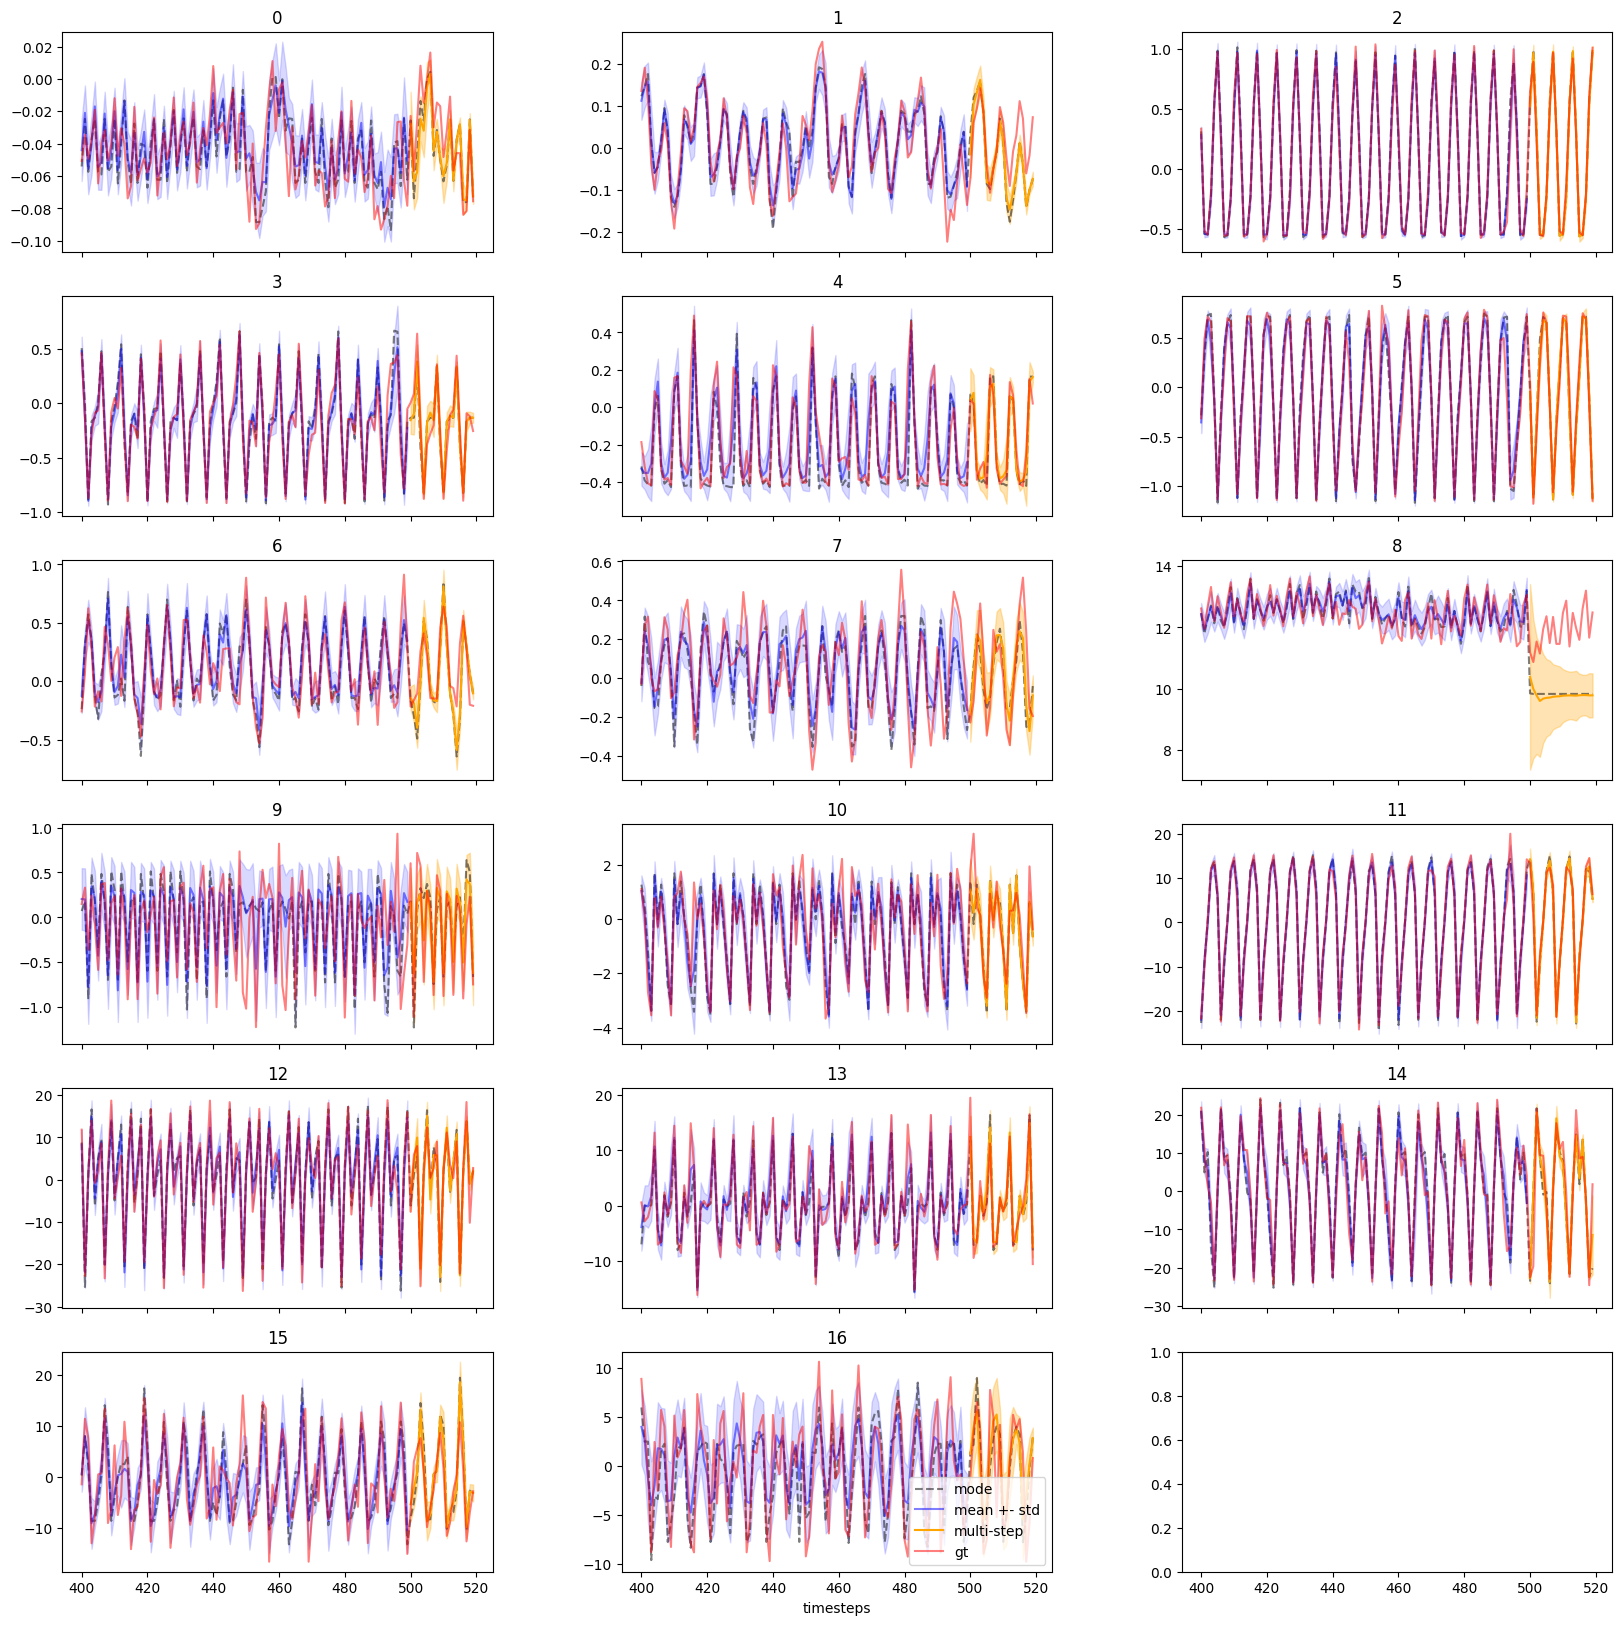

In [104]:
prediction_horizon = 20
context_length = 500
rescale_factor = 7.0
up_shift = 1.5

# env = gym.make('HalfCheetah-v4')
icl_trainer = ICLTrainer(env=None, model=model, tokenizer=tokenizer, rescale_factor=rescale_factor, up_shift=up_shift)

data_path = "/home/abenechehab/d4rl_halfcheetah/d4rl_expert_80k_20k/X_test.csv"
X, _, n_observations, n_actions = load_offline_dataset(path=data_path)
X = X[:, :n_observations]

init_index = 1006
icl_trainer.update_context(mv_time_series=X[init_index:init_index+context_length, :], context_length=context_length)
predictions = icl_trainer.icl(verbose=1) 
last_prediction = predictions[-1].reshape(1,-1)

# # extract last prediction
# statistics = icl_trainer.compute_statistics()

# print(f"---------------- before multi-step prediction ----------------")
# for dim in range(n_observations):
#     groundtruth = X[1:context_length+1, dim].flatten()
    
#     ts_max = icl_trainer.rescaling_max[dim]
#     ts_min = icl_trainer.rescaling_min[dim]
#     # -------------------- Useful for Plots --------------------
#     mode_arr = ((statistics[dim]['mode_arr'].flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min 
#     mean_arr = ((statistics[dim]['mean_arr'].flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min
#     sigma_arr = (statistics[dim]['sigma_arr'].flatten() / rescale_factor) * (ts_max - ts_min)

#     print(f"dim {dim} | last pred is {mode_arr[-1]}")
    
#     # -------------------- Trajectory visualization --------------------
#     x = np.arange(mean_arr.shape[0])
#     plt.figure()
#     plt.plot(x, mode_arr, 'k--',label='mode')
#     plt.plot(x, mean_arr, label='mean +- std', color='blue')
#     plt.fill_between(x=x, y1=mean_arr-sigma_arr, y2=mean_arr+sigma_arr)
#     plt.plot(x, groundtruth, label='gt', color='red')
#     plt.title(f"feature: {dim}")
#     plt.xlabel("timesteps")
#     plt.ylabel("feature")
#     plt.legend()
#     # plt.savefig(f"RL_figures/traj_{columns[feature] if all_dim else columns[dim]}_{policy}.png")
#     plt.show()

# multi-horizon pediction
# icl_trainer.predict_long_horizon_llm(state=last_prediction, h=prediction_horizon, temperature=1.0)
current_ts = copy.copy(X[:context_length, :])
for h in tqdm(range(prediction_horizon), desc="prediction_horizon"):
    icl_trainer.update_context(mv_time_series=np.concatenate([current_ts, last_prediction], axis=0), context_length=context_length+h+1, update_min_max=False)
    predictions = icl_trainer.icl(verbose=0) 
    statistics = icl_trainer.compute_statistics()
    current_ts = np.concatenate([current_ts, last_prediction], axis=0)
    last_prediction = predictions[-1].reshape(1,-1)
    
series_dict = icl_trainer.in_context_series
statistics = icl_trainer.compute_statistics()

print(f"---------------- after multi-step prediction ----------------")
f, axes = plt.subplots(6, 3, figsize=(20, 20), gridspec_kw={'wspace':0.3}, sharex=True)
axes = list(np.array(axes).flatten())
for dim in range(n_observations):
    groundtruth = X[1:context_length+1+prediction_horizon, dim].flatten()
    size_all = len(groundtruth)
    
    ts_max = icl_trainer.rescaling_max[dim]
    ts_min = icl_trainer.rescaling_min[dim]
    
    # -------------------- Useful for Plots --------------------
    mode_arr = ((statistics[dim]['mode_arr'].flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min 
    mean_arr = ((statistics[dim]['mean_arr'].flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min
    sigma_arr = (statistics[dim]['sigma_arr'].flatten() / rescale_factor) * (ts_max - ts_min)

    # -------------------- Trajectory visualization --------------------
    start_from = 400
    x = np.arange(mean_arr.shape[0])
    axes[dim].plot(x[start_from:], mode_arr[start_from:], 'k--', label='mode', alpha=.5)
    # single step
    axes[dim].plot(x[start_from:-prediction_horizon], mean_arr[start_from:-prediction_horizon], label='mean +- std', color='blue', alpha=.5)
    axes[dim].fill_between(
        x=x[start_from:-prediction_horizon], 
        y1=mean_arr[start_from:-prediction_horizon]-sigma_arr[start_from:-prediction_horizon], 
        y2=mean_arr[start_from:-prediction_horizon]+sigma_arr[start_from:-prediction_horizon],
        alpha=.15,
        color='blue'
    )
    # multi_step
    axes[dim].plot(x[-prediction_horizon:], mean_arr[-prediction_horizon:], label='multi-step', color='orange')
    axes[dim].fill_between(
        x=x[-prediction_horizon:], 
        y1=mean_arr[-prediction_horizon:]-sigma_arr[-prediction_horizon:], 
        y2=mean_arr[-prediction_horizon:]+sigma_arr[-prediction_horizon:],
        alpha=.3,
        color='orange'
    )

    axes[dim].plot(x[start_from:], groundtruth[start_from:], label='gt', color='red', alpha=.5)
    axes[dim].set_title(f"{dim}")
    if dim > 15:
        axes[dim].set_xlabel("timesteps")
    # axes[dim].set_ylabel("feature")
axes[dim].legend()
# f.suptitle(f'Halfcheetah - expert policy', y=-1.1)
plt.savefig(f"multi_step_halfcheetah_expert.png")
plt.show()